In [29]:
# Import all packages and functions needed for entire analysis
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pycountry
import re
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 12) 
import statsmodels.formula.api as sm

In [30]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [31]:
# Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

# Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

In [32]:
# Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)
Database = pd.concat([data_2019, data_2020], sort = False).reset_index(drop = True)

In [33]:
# Convert "Intensity (MMI / JMA)" Column from Roman Numerals to Integers
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
    
           
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [34]:
# Print Cleaned DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0


In [35]:
#Scrape Socioeconomic Information
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

In [36]:
# print DataFrame
gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


In [37]:
#Add GDP, Population and GDP per captia to lists for addition to DF

gdp_column = []
pop_column = []
gdp_per_cap_column = []

for i in range(len(earthquake_data)):
    country = earthquake_data.iloc[i, 1]
    if country == "Taiwan":
        gdp_column.append(586104000000)
        pop_column.append(23780452)
        gdp_per_cap_column.append(24828)
    if country == "Venezuela":
        gdp_column.append(70140000000)
        pop_column.append(28887118)
        gdp_per_cap_column.append(2548)
    if country == "Myamnar":
        gdp_column.append(355000000000)
        pop_column.append(53582855)
        gdp_per_cap_column.append(6707)
    if country == "Cayman Islands":
        gdp_column.append(4571000000)
        pop_column.append(68076)
        gdp_per_cap_column.append(70958)
    for j in range(len(gdp)):
        if gdp.iloc[j, 1] == country:
            gdp_column.append(gdp.iloc[j, 2])
            pop_column.append(gdp.iloc[j, 5])
            gdp_per_cap_column.append(gdp.iloc[j, 6])
            break

# Insert columns onto dataframe
earthquake_data.insert(loc = 13, column = 'GDP', value = gdp_column)
earthquake_data.insert(loc = 14, column = 'Population', value = pop_column)
earthquake_data.insert(loc = 15, column = 'GDPPerCapita', value = gdp_per_cap_column)

In [38]:
url1 = 'https://www.worldatlas.com/cntycont.htm'
url2='https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles'

response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continents'])
ConCun['Continents']=ConCun['Continents'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continents']=[title[0:len(title)-3] for title in ConCun['Continents']]

response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')
landmass['Landarea']=landmass['Landarea'].str.replace('square miles','').str.replace(',','')
time=[]
for tim in landmass['Landarea']:
    if 'million' in tim:
        time.append(float(tim[0:4])*1000000)
    else:
        time.append(float(tim))
landmass['Landarea']=time
Information=ConCun.join(landmass.set_index('Country'), on='Country')
earthquake_data=earthquake_data.join(Information.set_index('Country'), on='Country')

In [39]:
# print final DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed,GDP,Population,GDPPerCapita,Continents,Landarea
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0,1.943835e+12,60673701,32038,EUROPE,116346.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0,2.650725e+12,1338676785,1980,ASIA,1240000.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0,2.053595e+12,207833823,9881,S. AMERICA,3300000.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.061203e+09,877459,5768,OCEANIA,7095.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0,4.540128e+11,80673883,5628,ASIA,636313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,2.650725e+12,1338676785,1980,ASIA,1240000.0
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0,5.332063e+10,54660339,975,AFRICA,364900.0
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,4.540128e+11,80673883,5628,ASIA,636313.0
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0,4.540128e+11,80673883,5628,ASIA,636313.0


In [40]:
# Because of the frequency of earthquakes, USGS data takes all earthquake data all over the world and gives us the magnitude, longitude
#latitude, and depth. From there we can plot these on a Geomap or scatter plot and see if any patterns come up
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])

In [41]:
#Continueing to clean the data

time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

def latitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

latitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    latitude.append(latitudel(x))
    longitude.append(longitudel(y))

Current=pd.DataFrame(zip(time,Locate,magni,depth,latitude,longitude), columns=['time','Location','Magnitude','Depth (km)','latitude','longitude'])

def co(text):
    for country in pycountry.countries:
        if country.name in text:
            return(country.name)
t=[]
for i,text in enumerate(Current['Location']):
    j=re.findall(r",([\w\s]+)",text)
    if len(j)==0:
        if type(co(text)) is None:
            t.append(co(text))
        else:
            t.append(text)
    elif len(j)>0:
        t.extend(j)
    else:
        t.append(text)
Current['Country']=t
Current

,time,Location,Magnitude,Depth (km),latitude,longitude,Country
0,2020-04-10 18:45:49 UTC,"91km SSE of Pondaguitan, Philippines",5.1,76.92 km (47.80 mi),5.643,126.589,Philippines
1,2020-04-10 16:44:55 UTC,"15km E of Basco, Philippines",5.9,148.74 km (92.42 mi),20.427,122.120,Philippines
2,2020-04-10 16:38:06 UTC,"116km NNE of Bristol Island, South Sandwich I...",5.0,69.39 km (43.12 mi),-58.075,-25.716,South Sandwich Islands
3,2020-04-10 14:46:09 UTC,"86km SSW of Ile Hunter, New Caledonia",4.6,47.82 km (29.71 mi),-23.145,171.807,New Caledonia
4,2020-04-10 10:22:57 UTC,"42km S of Shizunai, Japan",4.5,59.85 km (37.19 mi),41.954,142.285,Japan
...,...,...,...,...,...,...,...
378,2020-03-12 07:27:38 UTC,Southern Mid-Atlantic Ridge,4.9,10.00 km (6.21 mi),-27.643,-13.314,Southern Mid-Atlantic Ridge
379,2020-03-12 06:08:54 UTC,"128km SE of L'Esperance Rock, New Zealand",4.6,10.00 km (6.21 mi),-32.371,-178.099,New Zealand
380,2020-03-12 05:20:13 UTC,"50km SE of Vilyuchinsk, Russia",4.7,78.70 km (48.90 mi),52.569,158.848,Russia
381,2020-03-12 03:57:59 UTC,"24km WSW of Palimbang, Philippines",4.6,10.00 km (6.21 mi),6.113,123.994,Philippines


In [42]:
# Create and display geomap of USGS Data
def cool(m):
    if 0<=m<1:
        return('green')
    elif 1<=m<2:
        return('orange')
    elif 2<=m<3:
        return('blue')
    elif 3<=m<4:
        return('teal')
    elif 5<=m<6:
        return('purple')
    elif 6<=m<7:
        return('amber')
    else:
        return('red')
    
nom=ArcGIS()
p=nom.geocode("Palais du Gouvernement,P.O. Box 4546,N'Djaména")
map=folium.Map(location=[p.latitude,p.longitude], zoom_start=2, tiles="Stamen Terrain")

html="""<h4><b>Earquakes Info</b></h4>
<p><b>Location: </b>%s</p>
<p><b>Magnitude: </b>%s</p>"""
fgv=folium.FeatureGroup(name="shake")
for la, lo, m,l in zip(latitude,longitude,magni,Locate):
    iframe=folium.IFrame(html=html %(l,str(m)),width=200,height=100)
    fgv.add_child(folium.CircleMarker(location=[la,lo],fill_color=cool(m),popup=folium.Popup(iframe),fill=True,color='black',fill_capacity=0.9))
map.add_child(fgv)

<Figure size 1080x1080 with 0 Axes>

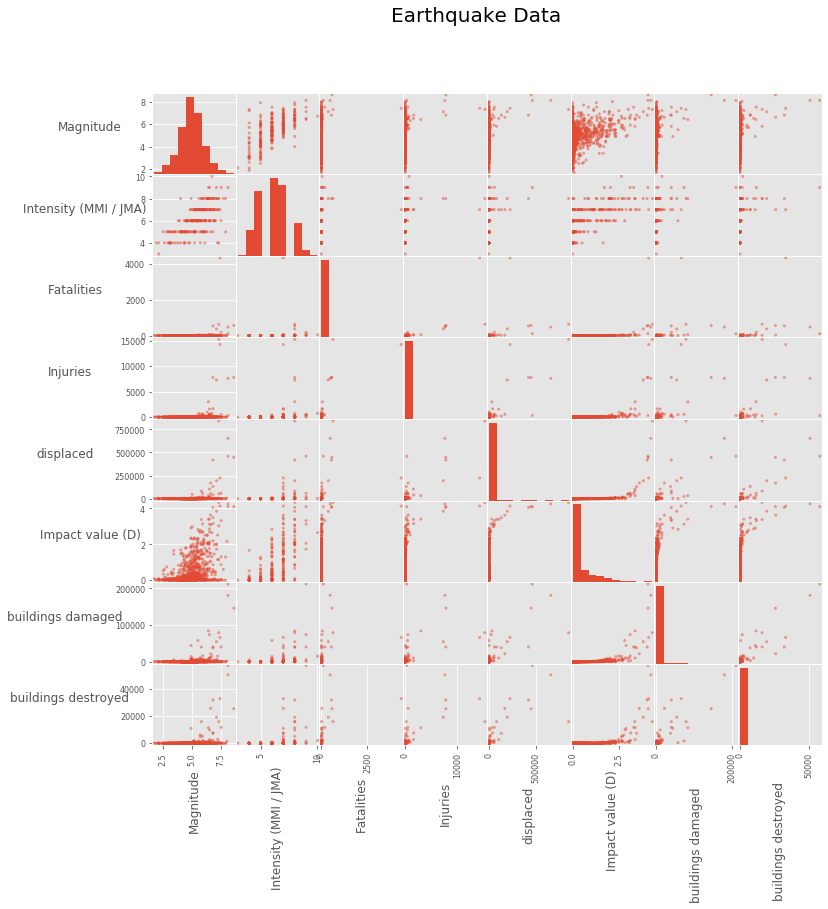

In [43]:
col=['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']
scattering=earthquake_data[col]
plt.figure(1, figsize = (15, 15))
axs=pd.plotting.scatter_matrix(scattering)
plt.suptitle('Earthquake Data', size=20)
n = len(scattering.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

Text(0.5, 1.0, 'Principal Component of States')

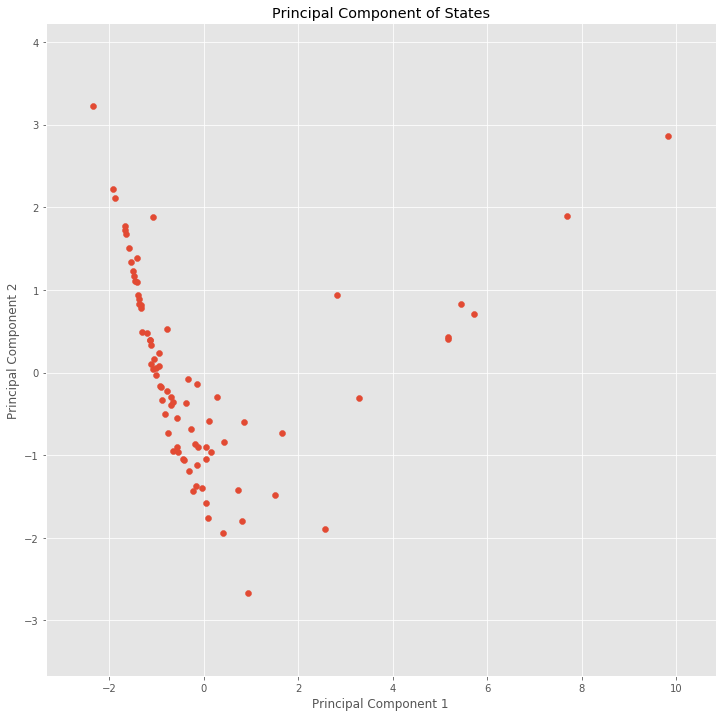

In [44]:
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

In [45]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57204901 0.17122451 0.1048144  0.06130814 0.04546535 0.02423484
 0.01563137 0.00527239]


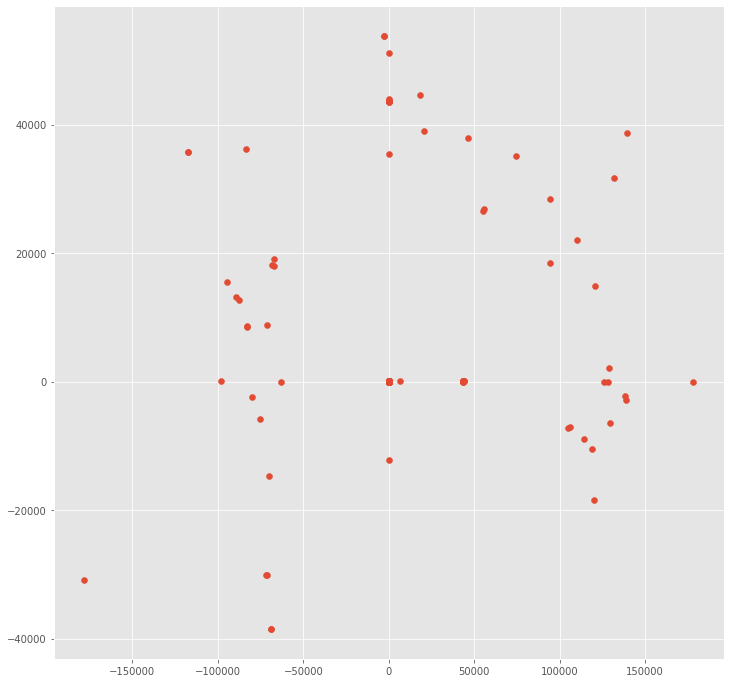

In [46]:
#Scatter from excel sheets
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

In [48]:
#Kmeans from USGS data. We will use k-means for all other data
quac=Current[['latitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=7,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
Current['grouping']=y_pred
Help=Current[['grouping','Country']]
T=Help.groupby('Country').mean().reset_index()
Info=Information.merge(T,how='left',left_on='Country', right_on='Country')
Info.groupby('grouping').count()
#plt.scatter(quac['longitude'],quac['latitude'],c=y_pred,cmap=cmap)

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Country,Continents,Landarea
grouping,,,


In [52]:
ch=Information['Country']
kip=T['Country']
for t in ch:
    if t in kip:
        print('yes')
    else:
        print('no')

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


In [50]:
T

,Country,grouping
0,Afghanistan,2.0
1,Alaska,5.0
2,Algeria,2.0
3,Argentina,1.0
4,Banda Sea,0.0
...,...,...
77,Vanuatu,6.0
78,Venezuela,3.0
79,Wallis and Futuna,4.0
80,West Chile Rise,1.0
